Net GHG/Revenue Impact of Load-Shifting Batteries

In [1]:
import os, sys
PWD = os.getenv('PWD')
os.chdir(PWD)
sys.path.insert(0, os.getenv('PWD'))
os.environ.setdefault("DJANGO_SETTINGS_MODULE", "local_settings.py")
import django
django.setup()

In [2]:
from datetime import datetime, timedelta

from beo_datastore.libs.battery import Battery
from beo_datastore.libs.battery_schedule import create_fixed_schedule, optimize_battery_schedule
from beo_datastore.libs.plot_intervalframe import (
        plot_frame288, plot_frame288_monthly_comparison, plot_intervalframe, plot_many_frame288s
)

from cost.ghg.models import GHGRate
from cost.optimization.models import MultiScenarioOptimization, SimulationOptimization
from cost.utility_rate.models import RatePlan
from der.simulation.models import BatteryConfiguration, BatterySchedule
from load.customer.models import Meter
from reference.reference_model.models import LoadServingEntity

In [3]:
# define battery specs and schedule

# create 5 kW @ 2 hours battery with 90% efficiency
battery = Battery(rating=5, discharge_duration=timedelta(hours=2), efficiency=0.9)
config_1, _ = BatteryConfiguration.get_or_create_from_battery(battery)

# create 10 kW @ 2 hours battery with 90% efficiency
battery = Battery(rating=10, discharge_duration=timedelta(hours=2), efficiency=0.86)
config_2, _ = BatteryConfiguration.get_or_create_from_battery(battery)

configs = [config_1, config_2]

In [4]:
load_serving_entity = LoadServingEntity.objects.get(name__contains="MCE")
rate_plan_name = "EV"
rate_plan = RatePlan.objects.get(name__contains=rate_plan_name, load_serving_entity=load_serving_entity)

# only charge on NEM exports
charge_schedule_1, _ = BatterySchedule.get_or_create_from_frame288(frame288=create_fixed_schedule(0, 0, 0, 0))
# always discharge between 4 p.m. and 9 p.m.
discharge_schedule_1, _ = BatterySchedule.get_or_create_from_frame288(frame288=create_fixed_schedule(16, 22, 0, float("inf")))

# define optimized Clean Net Short 2030 charge/discharge schedule
charge_frame288 = optimize_battery_schedule(
    frame288=GHGRate.objects.get(name="Clean Net Short", effective__year=2030),
    level=8,  # incremental level of schedule aggressiveness
    charge=True,  # True for charge schedule
    minimize=True,  # True to minimize cost function
    threshold=2,  # allow charging on meter reads up to 2kW (cannot charge from grid)
)
discharge_frame288 = optimize_battery_schedule(
    frame288=GHGRate.objects.get(name="Clean Net Short", effective__year=2030),
    level=8,  # incremental level of schedule aggressiveness
    charge=False,  # False for discharge schedule
    minimize=True,  # True to minimize cost function
    # threshold not set, so can discharge to grid
)
charge_schedule_2, _ = BatterySchedule.get_or_create_from_frame288(frame288=charge_frame288)
discharge_schedule_2, _ = BatterySchedule.get_or_create_from_frame288(frame288=discharge_frame288)

# define optimized utility bill charge/discharge schedule
rate_plan_frame288 = rate_plan.get_rate_frame288_by_year(2018, "energy", "weekday")
charge_frame288 = optimize_battery_schedule(
    frame288=rate_plan_frame288,
    level=1,  # incremental level of schedule aggressiveness
    charge=True,  # True for charge schedule
    minimize=False,  # False to maximize cost function
    threshold=0,  # allow charging on meter reads up to 0kW (cannot charge from grid)
)
discharge_frame288 = optimize_battery_schedule(
    frame288=rate_plan_frame288,
    level=1,  # incremental level of schedule aggressiveness
    charge=False,  # False for discharge schedule
    minimize=False,  # False to maximize cost function
    threshold=0,  # allow discharging on meter reads down to 0kW (cannot export to grid)
)
charge_schedule_3, _ = BatterySchedule.get_or_create_from_frame288(frame288=charge_frame288)
discharge_schedule_3, _ = BatterySchedule.get_or_create_from_frame288(frame288=discharge_frame288)

schedules = [
    (charge_schedule_1, discharge_schedule_1),
    (charge_schedule_2, discharge_schedule_2),
    (charge_schedule_3, discharge_schedule_3),
]

# view schedules
# display(rate_plan_frame288.dataframe)
# display(charge_schedule_2.frame288.dataframe)
# display(discharge_schedule_3.frame288.dataframe)

In [5]:
# create multi-scenario optimization
multi = MultiScenarioOptimization.objects.create()

# run simulation optimization
for config in configs:
    for charge_schedule, discharge_schedule in schedules:
        single, _ = SimulationOptimization.objects.get_or_create(
            start=datetime(2018, 1, 1),
            end_limit=datetime(2019, 1, 1),
            charge_schedule=charge_schedule,
            discharge_schedule=discharge_schedule,
            battery_configuration=config,
            rate_plan=rate_plan,
        )
        single.meters.add(*Meter.objects.filter(load_serving_entity=load_serving_entity))
        single.ghg_rates.add(*GHGRate.objects.filter(name="Clean Net Short"))
        single.ghg_rates.add(*GHGRate.objects.filter(name="CARB - Unspecified Power"))
        multi.simulation_optimizations.add(single)

multi.run(multiprocess=True)

In [6]:
# display bill and GHG impacts
display(multi.detailed_report)

,BillDelta,CleanNetShort2018Delta,CleanNetShort2022Delta,CleanNetShort2026Delta,CleanNetShort2030Delta,CARB-UnspecifiedPower2013Delta,SimulationOptimization,BatteryConfiguration,ChargeSchedule,DischargeSchedule,SimulationRatePlan,MeterRatePlan
SA_ID,,,,,,,,,,,,
0,-36.212045,0.009779,-0.031470,-0.023757,-0.107685,0.016451,1,5kW @ 2 hours (90.0% efficiency),1,2,"EV, Residential Rates for Electric Vehicle Owners",TEST
0,6.760300,0.002152,-0.001254,-0.000920,-0.006453,0.002257,6,10kW @ 2 hours (86.0% efficiency),5,6,"EV, Residential Rates for Electric Vehicle Owners",TEST
0,-280.722298,0.126136,-0.326032,-0.210666,-0.840353,0.184592,2,5kW @ 2 hours (90.0% efficiency),3,4,"EV, Residential Rates for Electric Vehicle Owners",TEST
0,6.722680,0.001514,-0.001919,-0.001584,-0.007094,0.001525,3,5kW @ 2 hours (90.0% efficiency),5,6,"EV, Residential Rates for Electric Vehicle Owners",TEST
0,-33.650985,0.015926,-0.025513,-0.017664,-0.101805,0.023154,4,10kW @ 2 hours (86.0% efficiency),1,2,"EV, Residential Rates for Electric Vehicle Owners",TEST
0,-297.564682,0.230788,-0.291245,-0.176197,-0.946402,0.299251,5,10kW @ 2 hours (86.0% efficiency),3,4,"EV, Residential Rates for Electric Vehicle Owners",TEST
7720534682,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1,5kW @ 2 hours (90.0% efficiency),1,2,"EV, Residential Rates for Electric Vehicle Owners","E19, Medium General Service, Primary"
7720534682,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2,5kW @ 2 hours (90.0% efficiency),3,4,"EV, Residential Rates for Electric Vehicle Owners","E19, Medium General Service, Primary"
7720534682,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3,5kW @ 2 hours (90.0% efficiency),5,6,"EV, Residential Rates for Electric Vehicle Owners","E19, Medium General Service, Primary"


In [7]:
# remove all existing filters
multi.reinitialize()

# filter simulations
multi.filter_by_query("BillDelta > -500")  # include only BillDelta > -500
multi.filter_by_transform("CleanNetShort2030Delta", min)  # limit results to min CleanNetShort2022Delta values 

In [8]:
# display bill and GHG impacts
display(multi.detailed_report)

,BillDelta,CleanNetShort2018Delta,CleanNetShort2022Delta,CleanNetShort2026Delta,CleanNetShort2030Delta,CARB-UnspecifiedPower2013Delta,SimulationOptimization,BatteryConfiguration,ChargeSchedule,DischargeSchedule,SimulationRatePlan,MeterRatePlan
0,-297.564682,0.230788,-0.291245,-0.176197,-0.946402,0.299251,5,10kW @ 2 hours (86.0% efficiency),3,4,"EV, Residential Rates for Electric Vehicle Owners",TEST
7720534682,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1,5kW @ 2 hours (90.0% efficiency),1,2,"EV, Residential Rates for Electric Vehicle Owners","E19, Medium General Service, Primary"
8943913372,-188.718678,0.124906,-0.350543,-0.259686,-0.763881,0.179988,2,5kW @ 2 hours (90.0% efficiency),3,4,"EV, Residential Rates for Electric Vehicle Owners","EV, Residential Rates for Electric Vehicle Owners"


In [9]:
# view schedules
# display(BatterySchedule.objects.get(id=1).frame288.dataframe)

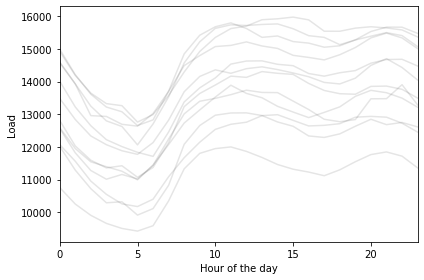

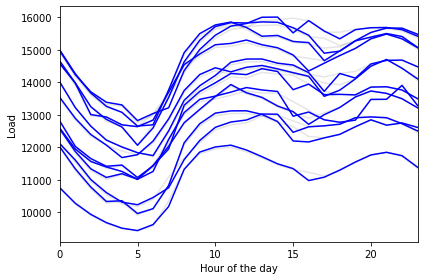

In [10]:
# plot all meters in study (combined into a single load profile)
frame288_type = "total_frame288"

# plot all meters combined before battery
plot_frame288(multi.aggregate_pre_intervalframe.total_frame288)
# compare all meteres combined after battery with before battery
plot_many_frame288s(
    [getattr(multi.aggregate_pre_intervalframe, frame288_type)],
    getattr(multi.aggregate_post_intervalframe, frame288_type),
)

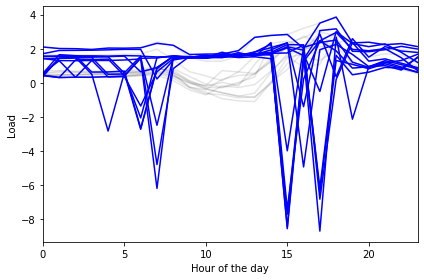

None

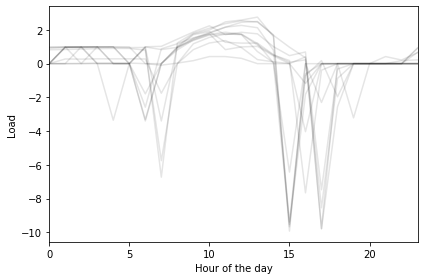

None

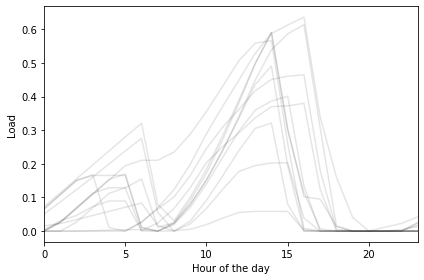

None

In [11]:
sa_id = 0

# examine battery operations for a single meter
battery_simulation = multi.battery_simulations.get(meter__sa_id=sa_id)
battery_intervalframe = battery_simulation.simulation.battery_intervalframe

# display average daily load before battery
display(plot_many_frame288s(
    [battery_simulation.pre_intervalframe.average_frame288],
    battery_simulation.post_intervalframe.average_frame288
))

# display average battery discharge
battery_intervalframe.aggregation_column = "kw"
display(plot_frame288(battery_intervalframe.average_frame288))

# display average battery state of charge
battery_intervalframe.aggregation_column = "charge"
charge_frame288 = battery_intervalframe.average_frame288
battery_intervalframe.aggregation_column = "capacity"
capacity_frame288 = battery_intervalframe.average_frame288
display(plot_frame288(charge_frame288/capacity_frame288))

In [12]:
# view individual before and after bills
bill_calculation = multi.bill_calculations.get(battery_simulation__meter__sa_id=sa_id)
bill_comparison = bill_calculation.bill_comparisons.get(start=datetime(2018, 7, 1))

display(bill_comparison.pre_DER_validation_bill.total_dataframe)
display(bill_comparison.post_DER_validation_bill.total_dataframe)

,category,description,tou_period,count,count_unit,rate,rate_unit,pro_rata,total
0,energy,Energy Charge - Summer Peak,0,353.433,kWh,0.212,$/kWh,1,74.927796
1,energy,Energy Charge - Summer Part-Peak,1,25.028,kWh,0.07,$/kWh,1,1.751960
2,energy,Energy Charge - Summer Off-Peak,2,148.446,kWh,0.022,$/kWh,1,3.265812
Total,,,,526.907,,,,,79.945568


,category,description,tou_period,count,count_unit,rate,rate_unit,pro_rata,total
0,energy,Energy Charge - Summer Peak,0,14.773,kWh,0.212,$/kWh,1,3.131876
1,energy,Energy Charge - Summer Part-Peak,1,166.343,kWh,0.07,$/kWh,1,11.644010
2,energy,Energy Charge - Summer Off-Peak,2,447.976,kWh,0.022,$/kWh,1,9.855472
Total,,,,629.092,,,,,24.631358


In [13]:
# view individual before and after monthly GHG emissions
ghg_calculation = multi.ghg_calculations.get(battery_simulation__meter__sa_id=sa_id, ghg_rate__name="Clean Net Short", ghg_rate__effective__year=2030)
display(ghg_calculation.aggregate_ghg_calculation.comparison_table)

,before,after
1,0.511071,0.501582
2,0.347845,0.305745
3,0.225872,0.145848
4,0.170487,0.083533
5,0.161172,0.085849
6,0.146498,0.018988
7,0.235341,0.099995
8,0.215508,0.126120
9,0.228950,0.167348
10,0.251416,0.142646
